In [223]:
from metal.label_model import LabelModel
from metal.analysis import lf_summary, label_coverage, single_lf_summary, error_buckets
from metal.label_model.baselines import MajorityLabelVoter
# from metal.viewer import SentenceNgramViewer

import re
import json
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from pandas.io.json import json_normalize
pd.set_option('display.max_colwidth', -1)

In [2]:
# unlabeled_comments_df = pd.read_csv('referendum_comments.csv')
# print(unlabeled_comments_df.count())
# unlabeled_comments_df.head()

text    8166
dtype: int64


,text
0,Asta este familia traditionala!👿👿👿
1,Ia să vedem cu ce ne mai surprinzi ce perle mai scoți pe gurița ta din căpușorul ăla gol cel porți pe umeri madam analfabeta secolului 😡
2,"si a trebuit sa mearga in bulgaria sa faca o crima,cind il avem in romania pe dracnea"
3,"Consider că viața nare limite și nu trebuie sa depindă de bani. E super intenția. Respect, respect."
4,"Biserica sa și vadă de Aminu ei și să nu se bage n politică!Boii ăștia îndepărtează lumea de biserica cu bună știință! Exact ca în cazul Islamismului, românii vor ajunge să și spargă capetele pe strada fiind prostiți de popi .Apare cate un ninjalau aparent credibil și i destul să i aburească pe proști"


In [3]:
# unlabeled_comments_df.drop_duplicates(inplace=True)
# #remove comments with less than 5 words
# unlabeled_comments_df = unlabeled_comments_df[unlabeled_comments_df['text'].apply(lambda x: len(x.split(' ')) > 4 )]
# unlabeled_comments_df = unlabeled_comments_df['text'].reset_index()
# unlabeled_comments_df.drop(columns=['index'], inplace=True)
# unlabeled_comments_df.count()

text    3872
dtype: int64

In [4]:
# unlabeled_comments_df.to_csv('comments_cleaned.csv')

In [5]:
#annotations from prodigy 

# json_path = "hate-speech-709labels.jsonl"
# j_content = []
# with open(json_path) as f:
#     for line in f:
#         j_content.append(json.loads(line))

# # Loading into pandas dataframe
# labeled_comments_df = json_normalize(j_content)
# labeled_comments_df = labeled_comments_df[['text', 'answer']]
# labeled_comments_df = labeled_comments_df[labeled_comments_df['answer'] != 'ignore']
# labeled_comments_df.rename(columns={'answer':'label'}, inplace=True)
# di = {'accept': 1, 'reject': 2}
# labeled_comments_df.replace({'label': di}, inplace=True)
# labeled_comments_df.drop_duplicates(inplace=True)
# #remove comments with less than 5 words
# labeled_comments_df = labeled_comments_df[labeled_comments_df['text'].apply(lambda x: len(x.split(' ')) > 4 )]
# labeled_comments_df.head()

,text,label
0,Bebelus aruncat in sacul de gunoi de cei ce trebuiau sa aibe grija de viata lui nemernici la puscarie,2
1,"Sa se duca si sa se mai intoarca,cand il astept eu in poarta🤬😡MUIE MULTA PSD🖕🏻🖕🏾💩",2
2,Cine te mai asculta infractorule stai dracu in banca ta ca ti-a trecut vremea.,2
4,"Nu le cunosc numele, dar cel in cămașa neagră care este homosexual, este cel mai inteligent dintre toți. Ca de obicei, traditionalii sunt tampi",2
5,"Nucleul ce stă la baza societății este familia. Familia are drepturi și obligații în societate. Obligația și datoria morală de bază a familiei este de a contribui la dezvoltarea și creșterea societății prin procreere, în primul rând. Atâta timp cât familia formată din două persoane de același sex nu poate respecta cea mai importantă datorie în societate, NU poate pretinde același drepturi!!! Restul e cancan.",1


In [247]:
#annotations from snorkel + manual correction
labeled_comments_df = pd.read_csv('hate-speech-labeled-corrected.csv', sep=';')
labeled_comments_df.drop(columns=['Unnamed: 0'], inplace=True)


unlabeled_comments_df = labeled_comments_df[1501:-1]
labeled_comments_df = labeled_comments_df[:1501]

In [248]:
unlabeled_comments_df = unlabeled_comments_df['text'].reset_index()
unlabeled_comments_df.drop(columns=['index'], inplace=True)

In [249]:
labeled_comments_df.groupby('label').count()

,text
label,
1,280
2,1221


In [250]:
labels = labeled_comments_df['label'].tolist()
comments = labeled_comments_df['text'].reset_index()
comments.drop(columns=['index'], inplace=True)

In [ ]:
FAMILY = r"""\b(da pentru familie|familia formată  prin căsătoria|familia heterosexuala|
                familia heterosexuală|mamă şi cu tată|mama şi tata|mama si tata|barbat si femeie|
                bărbat şi femeie|barbat şi femeie)"""
def contains_family_expressions(text):
    return POSITIVE if re.search(FAMILY, text) else ABSTAIN

In [251]:
ABSTAIN = 0 
POSITIVE = 1
NEGATIVE = 2

ANTI_REFERENDUM = r"""\b(manipulat|divizat|afacerişti|diaspora|propaganda|propagandă|referendumul este o manipulare|libertatea|parteneriat|civil|drepturi|referendum inutil|referundum penibil|referendum invalid|probleme mai grave|abuz de putere|manipulare|dezinformare|dezinforma)"""
def contains_antireferendum_expressions(text):
    return NEGATIVE if re.search(ANTI_REFERENDUM, text) else ABSTAIN

CHURCH = r"""\b(BOR|popi|preoțimea|preotimea|preoțime|preotime)"""
def contains_church_expressions(text):
    return NEGATIVE if re.search(CHURCH, text) else ABSTAIN

RIGHTS = r"""\b(comunitatea lgbt|libertatea|parteneriat|civil|drepturi|partenerial civil|drept|legalizarea parteneriatelor)"""
def contains_rights_expressions(text):
    return NEGATIVE if re.search(RIGHTS, text) else ABSTAIN

QUESTION = r"""\b(ambiguă|limba romana|limba română|formulat complicat|formulată complicat|formulata complicat|întrebare capcană|intrebare capcană|intrebare capcana|ambiguu|e ambiguă)"""
def contains_question_expressions(text):
    return NEGATIVE if re.search(QUESTION, text) else ABSTAIN

MONEY_USE = r"""\b(bani|bani pierduti|infrastrctura|infrastrctură|sanatate|sănătate|pensie|pensii|alocatie|alocatii|alocații|40 de mil|40 de milioane|43 de milioane|scoala|scoali|şcoala|şcoali|spital|spitale|orfelinat|orfelinate|bani mulți|bani multi|fraudă|frauda|autostrada|autostradă)"""
def contains_moneyuse_expressions(text):
    return NEGATIVE if re.search(MONEY_USE, text) else ABSTAIN

AGAINST_VOTE = r"""\b(stau acasa|stau acasă|stai acasa|stai acasă|nu votului|merg la plimbare|boicot|boicotez|boicotăm|boicotam|nu merg la vot)"""
def contains_against_vote_expressions(text):
    return NEGATIVE if re.search(AGAINST_VOTE, text) else ABSTAIN

AGAINST_POLITICIAN = r"""\b(hotiii?|tatuca|ciumei|infractor|infractorule|alegeri|alagerile|dady|daddy|muie|PSD|penal|penali|dragnea|dracnea|ciuma|ciumă|analfabeti|analfabeți|mafiot|mafioți|demisia|să-i împușcați|să-i omorâți|închiși|pușcărie|muie PSD)"""
def contains_against_politician_expressions(text):
    return NEGATIVE if re.search(AGAINST_POLITICIAN, text) else ABSTAIN

INSULT= r"""\b(putori|zoofili?|drogati?|necrofili?|bolnavi? mintal|debili?|vierme|nemernicia|nimicuri|scursuri|scârbos|scârboșenie|lucrui scârboase)"""
def contains_insult_expressions(text):
    return POSITIVE if re.search(INSULT, text) else ABSTAIN

OBSCEN= r"""\b(suge-ti|sugeti|suji|ia in cur|futu-te-n cur|fut in cur|lins in pizda|se fut in cur|fut|cur|poponet|poponeț|poponarii|poponar)"""
def contains_obscen_expressions(text):
    return POSITIVE if re.search(OBSCEN, text) else ABSTAIN

FAMILY = r"""\b(da pentru familie|familia formată  prin căsătoria|familia heterosexuala|familia heterosexuală|mamă şi cu tată|mama şi tata|mama si tata|barbat si femeie|bărbat şi femeie|barbat şi femeie)"""
def contains_family_expressions(text):
    return POSITIVE if re.search(FAMILY, text) else ABSTAIN

NORMALITY = r"""\b(bun simt|impotriva firii|împotriva firii|valori|normalitate|normal|lume normală|lume normala|valori autentice|valori morale|demnitate|moralitate|moralitatii)"""
def contains_normality_expressions(text):
    return POSITIVE if re.search(NORMALITY, text) else ABSTAIN

CHILDREN = r"""\b(copii|viitorul copiilor|furtul de copii|furturi de copii|viitorul nepoților|viitorul nepotilor|naste copii|naşte copii)"""
def contains_children_expressions(text):
    return POSITIVE if re.search(CHILDREN, text) else ABSTAIN

RELIGION = r"""\b(tara crestina|crestin|crestini|sodomiti|sodomitii|satan|satana|sodoma|gomora|sodoma si gomora|sodoma şi gomora|credința creştină|credinta crestina|ateu|atei|iisus|isus|hristos|dumnezeu|este păcat|este pacat|religie ortodoxă|diavol|diavolicesc|diavolesc|drăcesc)"""
def contains_religion_expressions(text):
    return POSITIVE if re.search(RELIGION, text) else ABSTAIN

IDEOLOGY = r"""\b(progresist|progresism|progresivismul|marxismul|sexo-marxismului|neomarxismului|neomarxism|globalizare|globalism|globalismului|ideologia|perversiuni|pervers|ideologie|ideologie de gen|trans|transgender|doi bărbați|doi barbati|două femei|doua femei)"""
def contains_ideology_expressions(text):
    return POSITIVE if re.search(IDEOLOGY, text) else ABSTAIN

HOMOSEXUALITY = r"""\b(homalaii|anal|bulangiu|bulangii|barbat cu barbat|bărbat cu bărbat|femeie cu femeie|masturbare|sida|hiv|activistilor lgbtq?|activist lgbtq|pro-?lgbt|anti-?lgtb|căsătoria gay|căsătorii gay|cuplu homosexual|victorie homosexialilor|victorie a homosexualilor|homalău|curcubeu|homosexual|lgbt|vin homosexualii|problema cu homosexualitatea|homo|ghei|lesbi|lezbi|homosexualii acestia|homosexualitatea este)"""
def contains_homosexuality_expressions(text):
    return POSITIVE if re.search(HOMOSEXUALITY, text) else ABSTAIN

PRO_VOTE = r"""\b(ne vedem la referendum|mobilizam|mobilizăm|petitia online|petiția|merg la vot|da votului|hai la referendum|hai la vot|votez da|votăm da|votam da|da pentru referendum)"""
def contains_pro_vote_expressions(text):
    return POSITIVE if re.search(PRO_VOTE, text) else ABSTAIN

PRO_REFERENDUM = r"""\b(3 milioane de crestini|3 milioane de creştini|initiativa|inițiativa|3 milioane de semnatari|3 milioane de semnături|3 milioane|3.000.000|3,000,000 de cetateni)"""
def contains_proreferendum_expressions(text):
    return POSITIVE if re.search(PRO_REFERENDUM, text) else ABSTAIN

# Termenul „homosexualitate”, poate fi încadrat la categoria de termeni ai DIU, prin raportarea
# negativă asupra acestora de către susținătorii faamilie tradiționale: „Problema cu homosexuali este o
# treaba serioasa...”, „vin homosexualii sa va ia copiii”„ homosexualitatea este o boala si un pacat”,
# „homosexualii acestia nenorociti din cauza carora Romania o duce atat de rau”, etc

In [252]:
LFs = [
    contains_against_politician_expressions,
    contains_rights_expressions,
    contains_church_expressions,
    contains_question_expressions,
    contains_moneyuse_expressions,
    contains_against_vote_expressions,
    contains_antireferendum_expressions,
    contains_children_expressions,
    contains_family_expressions,
    contains_normality_expressions,
    contains_insult_expressions,
    contains_pro_vote_expressions,
    contains_ideology_expressions,
    contains_obscen_expressions,
    contains_homosexuality_expressions,
#     contains_proreferendum_expressions,
    contains_religion_expressions
]

LF_names = [
    'against_politician',
    'rights',
    'church',
    'question',
    'money_use',
    'against_vote',
    'antireferendum',
    'children',
    'family',
    'normality',
    'insult',
    'pro_vote',
    'ideology',
    'obscen',
    'homosexuality',
#     'proreferendum',
    'religion'
]

In [253]:
def make_Ls_matrix(data, LFs):
    noisy_labels = np.empty((len(data), len(LFs)))
    for i, row in data.iterrows():
        for j, lf in enumerate(LFs):
            noisy_labels[i][j] = lf(row.values[0].lower())
    return noisy_labels

In [254]:
LF_matrix = make_Ls_matrix(comments, LFs)
Y_LF_set = np.array([labels[i] for i in range(len(labels))])

In [255]:
print(LF_matrix.shape)
print(Y_LF_set.shape)
print(len(LF_names))
print(len(LFs))

(1501, 16)
(1501,)
16
16


In [256]:
lf_summary(sparse.csr_matrix(LF_matrix),
           Y=Y_LF_set,
           lf_names=LF_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
against_politician,0,2.0,0.092605,0.044637,0.027315,124,15,0.892086
rights,1,2.0,0.073284,0.063957,0.039973,84,26,0.763636
church,2,2.0,0.010660,0.006662,0.003331,16,0,1.000000
question,3,2.0,0.005996,0.002665,0.001999,8,1,0.888889
money_use,4,2.0,0.083944,0.045969,0.033311,117,9,0.928571
against_vote,5,2.0,0.031979,0.020653,0.013991,41,7,0.854167
antireferendum,6,2.0,0.083278,0.063291,0.040640,98,27,0.784000
children,7,1.0,0.115256,0.099267,0.035310,92,81,0.531792
family,8,1.0,0.017322,0.015989,0.002665,20,6,0.769231
normality,9,1.0,0.097268,0.075949,0.019320,91,55,0.623288


In [257]:
#error analysis
noisy_labels = np.empty((len(comments)))
for i, row in comments.iterrows():
    noisy_labels[i] = contains_insult_expressions(row.values[0].lower())

# buckets[1,1] = true positives
# buckets[1,2] = false positives
# buckets[2,1] = false negatives
# buckets[2,2] = true negatives    
buckets = error_buckets(labels, noisy_labels.tolist(), comments['text'].tolist())

In [258]:
LF_matrix = make_Ls_matrix(comments, LFs)
print("Overall, we reach a coverage ratio of", round(label_coverage(LF_matrix), 2), "over the training subset.")

LF_matrix_full_dataset = make_Ls_matrix(unlabeled_comments_df, LFs)
print("Overall, we reach a coverage ratio of", round(label_coverage(LF_matrix_full_dataset), 2), "over the whole training set.")

Overall, we reach a coverage ratio of 0.56 over the training subset.
Overall, we reach a coverage ratio of 0.46 over the whole training set.


In [259]:
def covered_data_points(L):
    """Returns an indicator vector where ith element = 1 if x_i is labeled by at
    least one LF."""
    return np.ravel(np.where(L.sum(axis=1) != 0, 1, 0))

covered_vec = covered_data_points(LF_matrix_full_dataset)
i, = np.where(covered_vec == 0)
print(unlabeled_comments_df.iloc[i].count())
# unlabeled_comments_df.iloc[i]['text'].tolist()

text    1268
dtype: int64


In [260]:
mv = MajorityLabelVoter()
Ls_train = make_Ls_matrix(comments, LFs)

mv = MajorityLabelVoter(seed=42)
print("Basic majority vote labels performance:")
scores = mv.score((Ls_train, Y_LF_set), metric=['accuracy','precision', 'recall', 'f1'])

Basic majority vote labels performance:
Accuracy: 0.597
Precision: 0.300
Recall: 0.871
F1: 0.446
        y=1    y=2   
 l=1    244    569   
 l=2    36     652   


In [261]:
Ls_train = make_Ls_matrix(comments, LFs)

label_model = LabelModel(k=2, seed=42)
label_model.train_model(Ls_train,
                        Y_dev=Y_LF_set,
                        n_epochs=1000,
                        lr=0.0001,
                        class_balance=np.array([0.2, 0.8]),
                        log_train_every=2000)

Computing O...
Estimating \mu...
Finished Training


In [262]:
Ls_train = make_Ls_matrix(comments, LFs)
Y_train_ps = label_model.predict_proba(Ls_train)

print("Snorkel generated labels performance:")
scores = label_model.score((Ls_train, Y_LF_set), metric=['accuracy','precision', 'recall', 'f1'])

Snorkel generated labels performance:
Accuracy: 0.884
Precision: 0.750
Recall: 0.568
F1: 0.646
        y=1    y=2   
 l=1    159    53    
 l=2    121   1168   


In [263]:
#label the whole dataset with trained model function
Ls_train_full = make_Ls_matrix(unlabeled_comments_df, LFs)
Y_train_full = label_model.predict(Ls_train_full)
comments_labels = pd.DataFrame(Y_train_full, columns=['label'])
comments_labels_full = pd.concat([unlabeled_comments_df, comments_labels], axis=1)
comments_labels_full.groupby('label').count()

,text
label,
2,2358


In [211]:
# iterate over the new labels and add them to the corrected dataset

# labeled_comments_df.sort_values(by='label', inplace=True)
# comments_labels_full.sort_values(by='label', inplace=True)

# frame_for_csv = pd.concat([labeled_comments_df, comments_labels_full])
# frame_for_csv.groupby('label').count()
# print(frame_for_csv.count())

# frame_for_csv.to_csv('hate-speech-labeled-corrected.csv')

text     2863
label    2863
dtype: int64
text     1000
label    1000
dtype: int64


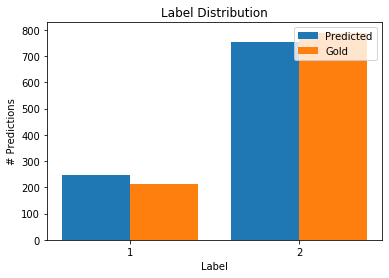

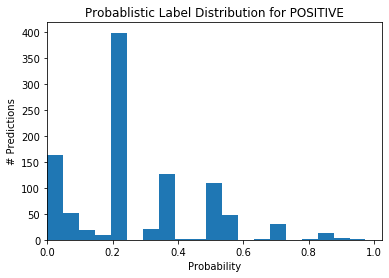

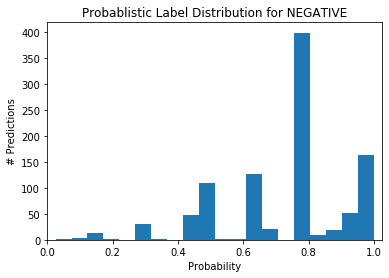

In [218]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)

plot_predictions_histogram(Y_LF_set,
                           label_model.predict(Ls_train),
                           title="Label Distribution")

Y_dev_ps = label_model.predict_proba(Ls_train)
plot_probabilities_histogram(Y_dev_ps[:, 0],
                             title="Probablistic Label Distribution for POSITIVE")
plot_probabilities_histogram(Y_dev_ps[:, 1],
                             title="Probablistic Label Distribution for NEGATIVE")


In [219]:
print(unlabeled_comments_df.iloc[500][0], "\n\n", Y_train_ps[500])

O întrebare către susținătorii referendumului pentru Adam și Eva:  Am nevoie de o lămurire cu privire la teoria evoluției omenirii în varianta religioasă/biblică. Conform bibliei,avem: Dumbezeu=>Adam și Eva=>Cain,Abel și Set. Cum a evoluat specia umana(cum s-au înmulțit)? Prin incest? Printr-un incest perpetu? Mulțumesc anticipat! 

 [0.2 0.8]


In [220]:
print(unlabeled_comments_df.iloc[700][0], "\n\n", Y_train_ps[700])

Voi credeți că dacă se face REFERENDUM dispare homosexuali aici ie mana lui Cariatul de Dragnea sa mai fure niște bani 

 [0.2 0.8]


In [221]:
print("POSITIVE for hate:", "\n")
pos_sorted_idx = np.argsort(Y_train_ps[:, 0])
print(pos_sorted_idx[-5:], "\n")
for i in range(5):
    idx = pos_sorted_idx[-i-1]
    print(unlabeled_comments_df.iloc[idx][0], "\n")
    print(Y_train_ps[idx])
    print('-' * 115)

POSITIVE for hate: 

[210 156  46 141 232] 

Nu merg la vot!! E cel mai bine!! Refuz sa merg la vot. 

[0.97421036 0.02578964]
-------------------------------------------------------------------------------------------------------------------
Gunoaiele astea au facut României mai mult rău decât bine ! La noi este o lupta pentru suprematie , Romania merge la vale..... 

[0.91819882 0.08180118]
-------------------------------------------------------------------------------------------------------------------
Va dati mari credinciosi dar ati vrea sa ii razuiti/impuscati/strangeti de gat...vai mama voastra....de credinta nu mai zic... 

[0.91622265 0.08377735]
-------------------------------------------------------------------------------------------------------------------
Bravo băieți !!! I-ați sfidat!!!! 

[0.91270568 0.08729432]
-------------------------------------------------------------------------------------------------------------------
Votăm da pentru familia dintr-un bărbat și 

In [222]:
print("NEGATIVE for hate:", "\n")
neg_sorted_idx = np.argsort(Y_train_ps[:, 1])
print(neg_sorted_idx[-5:], "\n")
for i in range(5):
    idx = neg_sorted_idx[-i-1]
    print(unlabeled_comments_df.iloc[idx][0], "\n")
    print(Y_train_ps[idx])
    print('-' * 115)

NEGATIVE for hate: 

[534 346 399 104 621] 

Mai se scurg 4 milioane de euro în loc să construiți spitale că mor copii pe capete și bătrînii și vouă nici că nu vă pasă. Așa să vă ajute bunul Dumnezeu pe cum faceți. Amin 

[4.17125947e-04 9.99582874e-01]
-------------------------------------------------------------------------------------------------------------------
Ma idiotilor care cheltuiti banii nostri lasati porcaria asta si occupati Va de probleme mai importante 

[4.73465804e-04 9.99526534e-01]
-------------------------------------------------------------------------------------------------------------------
Proastă tari demisia habar nu ai sa vb corect și coerent limba română 

[5.87493013e-04 9.99412507e-01]
-------------------------------------------------------------------------------------------------------------------
Toti oameni fara valori sant "penali" Tocmai s-a pierdut un Referendum al valorilor fara "penali" dar ati pierdut șansa. 

[8.55143938e-04 9.99144856e-01]
-